
# Synthèse annuelle du Zèbre

In [87]:
import pandas as pd
import numpy as np
from datetime import datetime as dt
from datetime import date
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

from kiblib.utils import lucas_sns_params

from kiblib.adherent import Adherent

from kiblib.utils.db import DbConn
from kiblib.utils.code2libelle import Code2Libelle


db_conn = DbConn().create_engine()

In [88]:
# Définition de quelques fonctions utiles

In [89]:
# Fonction pour récupérer les tranches d'âge

def add_AgeLib2(df,column):
    
    df[column] = df[column].astype(str)

    df.loc[df[column].between('0','14'),['age_lib_1']] = '0-14 ans'
    df.loc[df[column].between('14','999'),['age_lib_1']] = '15 ans et plus'

    # Age_lib_2
    df.loc[df[column].between('0','14'),['age_lib_2']] = '0-14 ans'
    df.loc[df[column].between('15','24'),['age_lib_2']] = '15-24 ans'
    df.loc[df[column].between('25','64'),['age_lib_2']] = '25-64 ans'
    df.loc[df[column].between('65','999'),['age_lib_2']] = '65 ans et plus'

    # Age_lib_3
    df.loc[df[column].between('0','2'),['age_lib_3']] = '0-2 ans'
    df.loc[df[column].between('3','5'),['age_lib_3']] = '3-5 ans'
    df.loc[df[column].between('6','10'),['age_lib_3']] = '6-10 ans'
    df.loc[df[column].between('11','14'),['age_lib_3']] = '11-14 ans'
    df.loc[df[column].between('15','17'),['age_lib_3']] = '15-17 ans'
    df.loc[df[column].between('18','19'),['age_lib_3']] = '18-19 ans'
    df.loc[df[column].between('20','24'),['age_lib_3']] = '20-24 ans'
    df.loc[df[column].between('25','29'),['age_lib_3']] = '25-29 ans'
    df.loc[df[column].between('30','39'),['age_lib_3']] = '30-39 ans'
    df.loc[df[column].between('40','54'),['age_lib_3']] = '40-54 ans'
    df.loc[df[column].between('55','64'),['age_lib_3']] = '55-64 ans'
    df.loc[df[column].between('65','79'),['age_lib_3']] = '65-79 ans'
    df.loc[df[column].between('80','999'),['age_lib_3']] = '80 ans et plus'
    
    print('Tranches d\'age ajoutées')

In [90]:
def add_FrequenceVenues(df,column):
    df.loc[df[column]==0,['Fréquence de venues']] = 'a/ Jamais'
    df.loc[df[column]==1,['Fréquence de venues']] = 'b/ 1 fois'
    df.loc[df[column].between(2,4),['Fréquence de venues']] = 'c/ Entre 2 et 4 fois'
    df.loc[df[column].between(5,9),['Fréquence de venues']] = 'd/ Entre 5 et 9 fois'
    df.loc[df[column].between(10,20),['Fréquence de venues']] = 'e/ Entre 10 et 20 fois'
    df.loc[df[column].between(21,50),['Fréquence de venues']] = 'f/ Entre 21 et 50 fois'
    df.loc[df[column]>50,['Fréquence de venues']] = 'g/ Plus de 50 fois'
    print('Fréquence de venues ajoutées')

In [91]:
def add_FideliteInscription(df,column):
    df.loc[df[column]==0,['FideliteInscription']] = "a/ Moins d'1 an"
    df.loc[df[column]==1,['FideliteInscription']] = "b/ 1 an"
    df.loc[df[column]==2,['FideliteInscription']] = "c/ 2 ans"
    df.loc[df[column]==3,['FideliteInscription']] = "d/ 3 ans"
    df.loc[df[column]==4,['FideliteInscription']] = "e/ 4 ans"
    df.loc[df[column].between(5,10),['FideliteInscription']] = "f/ Entre 5 et 10 ans"
    df.loc[df[column]>10,['FideliteInscription']] = 'g/ Plus de 10 ans'
    
    print('Info Fidélité inscription ajoutées')

In [92]:
def get_RepartitionAdherents(df,column,filter_on=None,filter_value=None):
    
    if filter_on and filter_value:
        df.loc[:,['nb_adherents']] = 1
        #df.loc[:,'nb_adherents'] = 1

        df = df[df[filter_on]==filter_value].pivot_table(index=column,
                                values='nb_adherents',
                                aggfunc=sum)
        df['part_en_%'] = round((df['nb_adherents']/df['nb_adherents'].sum())*100,0).astype(int)

        return(df)
        
        
    else:

        df.loc[:,['nb_adherents']] = 1
        #df.loc[:,'nb_adherents'] = 1

        df = df.pivot_table(index=column,
                                values='nb_adherents',
                                aggfunc=sum)
        df['part_en_%'] = round((df['nb_adherents']/df['nb_adherents'].sum())*100,0).astype(int)

        return(df)

In [93]:
def get_RepartitionPrets(df,column,filter_on=None,filter_value=None):
    
    if filter_on and filter_value:
        #df.loc[:,['nb_prets']] = 1
        df.loc[:,'nb_prets'] = 1

        df = df[df[filter_on]==filter_value].pivot_table(index=column,
                                values='nb_prets',
                                aggfunc=sum)
        df['part_en_%'] = round((df['nb_prets']/df['nb_prets'].sum())*100,0).astype(int)

        return(df)
        
        
    else:

        #df.loc[:,['nb_prets']] = 1
        df.loc[:,'nb_prets'] = 1

        df = df.pivot_table(index=column,
                                values='nb_prets',
                                aggfunc=sum)
        df['part_en_%'] = round((df['nb_prets']/df['nb_prets'].sum())*100,0).astype(int)

        return(df)

In [94]:
# Création de variables années

thisyear = dt.today().year
last_year = dt.today().year - 1
ref_year = dt(2019,1,1).year

In [95]:
last_year_str = str(last_year)

In [96]:
# On extrait de statdb la liste des adhérents
# fin 2019 et fin 2023

query = f"""SELECT *
FROM statdb.stat_adherents sa
WHERE date_extraction = (
	SELECT MAX(date_extraction)
	FROM statdb.stat_adherents sa
	WHERE YEAR(date_extraction) = '{ref_year}'
	)
OR date_extraction = (
	SELECT MAX(date_extraction)
	FROM statdb.stat_adherents sa2 
	WHERE YEAR(date_extraction) = '{last_year}'
	)"""

In [97]:
adh = pd.read_sql(query,db_conn)

In [98]:
# Ajout des infos dans le df général
adh['date_extraction'] = adh['date_extraction'].astype(str)

add_AgeLib2(df=adh,column='age')
add_FrequenceVenues(df=adh,column='nb_venues')
add_FideliteInscription(df=adh,column='inscription_fidelite')

Tranches d'age ajoutées
Fréquence de venues ajoutées
Info Fidélité inscription ajoutées


In [99]:
adh['nb_adherents'] = 1

In [100]:
adh_bus = adh[adh['inscription_code_site']=='BUS']

In [101]:
# Ajout de l'info VENUS EMPRUNTER AU MOINS UNE FOIS
adh.loc[(adh['nb_venues_prets_mediatheque']+adh['nb_venues_prets_bus']>0),['venues_prets?']] = 'a/ Déjà venus emprunter'
adh.loc[(adh['nb_venues_prets_mediatheque']+adh['nb_venues_prets_bus']==0),['venues_prets?']] = 'b/ Jamais venus emprunter'

In [102]:
# ZEBRE
adh.loc[(adh['inscription_code_site']=='BUS')&
        (adh['nb_venues_prets_bus']>=1)&
        (adh['nb_venues_prets_mediatheque']==0),
        ['CirculationDesPublics']] = 'a/ Inscrit BUS\n empr. au BUS '

adh.loc[(adh['inscription_code_site']=='BUS')&
        (adh['nb_venues_prets_bus']==0)&
        (adh['nb_venues_prets_mediatheque']>=1),
        ['CirculationDesPublics']] = 'b/ Inscrit BUS\n empr. en MED '

adh.loc[(adh['inscription_code_site']=='BUS')&
        (adh['nb_venues_prets_bus']>=1)&
        (adh['nb_venues_prets_mediatheque']>=1),
        ['CirculationDesPublics']] = 'c/ Inscrit BUS\n empr. aux 2'

adh.loc[(adh['inscription_code_site']=='BUS')&
        (adh['nb_venues_prets_bus']==0)&
        (adh['nb_venues_prets_mediatheque']==0),
        ['CirculationDesPublics']] = 'd/ Inscrit BUS\n empr. jamais'

# MEDIATHEQUE
adh.loc[(adh['inscription_code_site']=='MED')&
        (adh['nb_venues_prets_bus']>=1)&
        (adh['nb_venues_prets_mediatheque']==0),
        ['CirculationDesPublics']] = 'e/ Inscrit MED\n empr. au BUS '

adh.loc[(adh['inscription_code_site']=='MED')&
        (adh['nb_venues_prets_bus']==0)&
        (adh['nb_venues_prets_mediatheque']>=1),
        ['CirculationDesPublics']] = 'f/ Inscrit MED\n empr. en MED '

adh.loc[(adh['inscription_code_site']=='MED')&
        (adh['nb_venues_prets_bus']>=1)&
        (adh['nb_venues_prets_mediatheque']>=1),
        ['CirculationDesPublics']] = 'g/ Inscrit MED\n empr. aux 2'

adh.loc[(adh['inscription_code_site']=='MED')&
        (adh['nb_venues_prets_bus']==0)&
        (adh['nb_venues_prets_mediatheque']==0),
        ['CirculationDesPublics']] = 'h/ Inscrit MED\n empr. jamais'

In [103]:
adh_refyear = adh[adh['date_extraction'].str.startswith((str(ref_year)))]
adh_lastyear = adh[adh['date_extraction'].str.startswith(str(last_year))]

In [104]:
adh_refyear_bus = adh_refyear[adh_refyear['inscription_code_site']=='BUS']
adh_refyear_med = adh_refyear[adh_refyear['inscription_code_site']=='MED']

adh_lastyear_bus = adh_lastyear[adh_lastyear['inscription_code_site']=='BUS']
adh_lastyear_med = adh_lastyear[adh_lastyear['inscription_code_site']=='MED']

In [105]:
# REPARTITION ADH PAR SITE
repartition_adh_refyear_by_site = get_RepartitionAdherents(df=adh_refyear,column='inscription_code_site')
repartition_adh_lastyear_by_site = get_RepartitionAdherents(df=adh_lastyear,column='inscription_code_site')

In [20]:
# REPARTITION ADHERENTS BUS PAR AGE
repartition_adh_bus_refyear_by_age = get_RepartitionAdherents(df=adh_refyear,
                                                          column='age_lib_2',
                                                          filter_on='inscription_code_site',
                                                          filter_value='BUS'
                                                         )


repartition_adh_bus_lastyear_by_age = get_RepartitionAdherents(df=adh_lastyear,
                                                           column='age_lib_2',
                                                           filter_on='inscription_code_site',
                                                           filter_value='BUS'
                                                          )

In [21]:
# REPARTITION ADHERENTS MED PAR AGE
repartition_adh_med_refyear_by_age = get_RepartitionAdherents(df=adh_refyear,
                                                          column='age_lib_2',
                                                          filter_on='inscription_code_site',
                                                          filter_value='MED'
                                                         )


repartition_adh_med_lastyear_by_age = get_RepartitionAdherents(df=adh_lastyear,
                                                           column='age_lib_2',
                                                           filter_on='inscription_code_site',
                                                           filter_value='MED'
                                                          )

In [22]:
# REPARTITION DES EMPRUNTEURS DISTINCTS

repartition_empr_distincts_bus_lastyear = get_RepartitionAdherents(df=adh_lastyear,
                                                                column=adh_lastyear['venues_prets?'],
                                                                filter_on='inscription_code_site',
                                                                filter_value='BUS'
                                                               )

repartition_empr_distincts_bus_refyear = get_RepartitionAdherents(df=adh_refyear,
                                                                column=adh_refyear['venues_prets?'],
                                                                filter_on='inscription_code_site',
                                                                filter_value='BUS'
                                                               )

In [23]:
repartition_empr_distincts_med_lastyear = get_RepartitionAdherents(df=adh_lastyear,
                                                                column=adh_lastyear['venues_prets?'],
                                                                filter_on='inscription_code_site',
                                                                filter_value='MED'
                                                               )

repartition_empr_distincts_med_refyear = get_RepartitionAdherents(df=adh_refyear,
                                                                column=adh_refyear['venues_prets?'],
                                                                filter_on='inscription_code_site',
                                                                filter_value='MED'
                                                               )

In [24]:
adh_activite_empr_inscr_bus_refyear = get_RepartitionAdherents(df=adh_refyear_bus,column='CirculationDesPublics')
adh_activite_empr_inscr_med_refyear = get_RepartitionAdherents(df=adh_refyear_med,column='CirculationDesPublics')

adh_activite_empr_inscr_bus_lastyear = get_RepartitionAdherents(df=adh_lastyear_bus,column='CirculationDesPublics')
adh_activite_empr_inscr_med_lastyear = get_RepartitionAdherents(df=adh_lastyear_med,column='CirculationDesPublics')

# Répartition du nombre d'inscrits
## Par site d'inscription

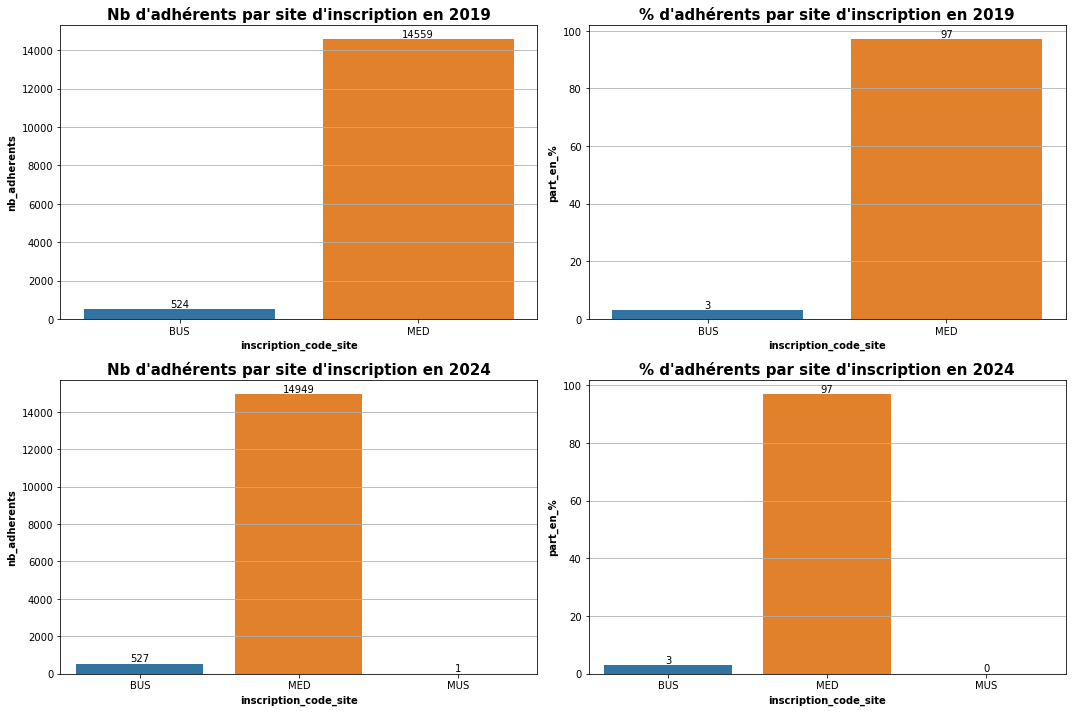

In [25]:
f,axs = plt.subplots(2,2,figsize=(15,10))

# FIGURE 1
sns.barplot(data=repartition_adh_refyear_by_site,
            x=repartition_adh_refyear_by_site.index,
            y='nb_adherents',
            ax=axs[0,0]
           )
# FIGURE 2   
sns.barplot(data=repartition_adh_refyear_by_site,
            x=repartition_adh_refyear_by_site.index,
            y='part_en_%',
            ax=axs[0,1]
           )

# FIGURE 3
sns.barplot(data=repartition_adh_lastyear_by_site,
            x=repartition_adh_lastyear_by_site.index,
            y='nb_adherents',
            ax=axs[1,0]
           )
# FIGURE 4
sns.barplot(data=repartition_adh_lastyear_by_site,
            x=repartition_adh_lastyear_by_site.index,
            y='part_en_%',
            ax=axs[1,1]
           )

# TITRES
axs[0,0].set_title(f"Nb d'adhérents par site d'inscription en {ref_year}")
axs[0,1].set_title(f"% d'adhérents par site d'inscription en {ref_year}")
axs[1,0].set_title(f"Nb d'adhérents par site d'inscription en {last_year}")
axs[1,1].set_title(f"% d'adhérents par site d'inscription en {last_year}")

a=0
b=0
x=0
for x in range(0,4):
    for i in axs[a,b].containers:
        axs[a,b].bar_label(i,)
        if x % 2 > 0:
            a+=1
            b=0
        else:
            a+=0
            b=1

f.tight_layout()

## Par Tranche d'âge

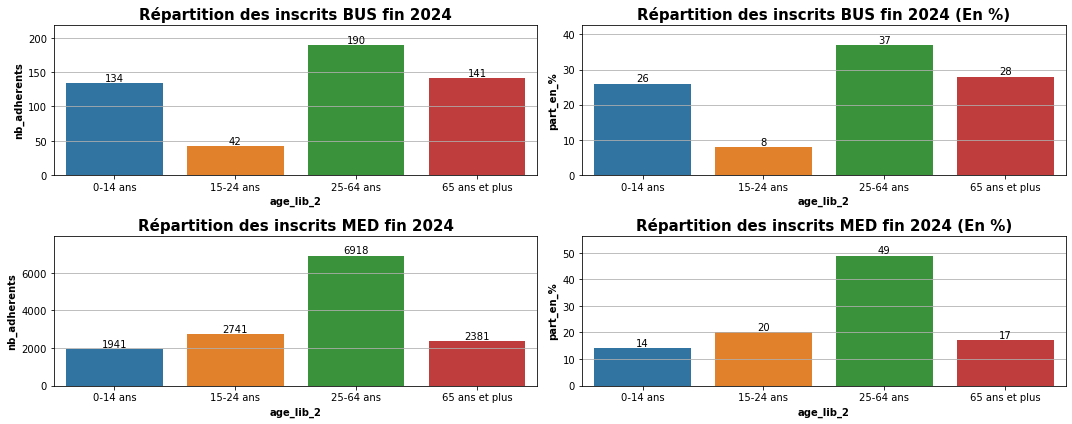

In [26]:
f,axs = plt.subplots(nrows=2,ncols=2,
                    # sharex=True,sharey=True
                    )

# Inscrits BUS
sns.barplot(data=repartition_adh_bus_lastyear_by_age,
            x=repartition_adh_bus_lastyear_by_age.index,
            y='nb_adherents',
            ax=axs[0,0])
axs[0,0].set_ylim(top=repartition_adh_bus_lastyear_by_age['nb_adherents'].max()*1.15)

        
sns.barplot(data=repartition_adh_bus_lastyear_by_age,
            x=repartition_adh_bus_lastyear_by_age.index,
            y='part_en_%',
            ax=axs[0,1])
axs[0,1].set_ylim(top=repartition_adh_bus_lastyear_by_age['part_en_%'].max()*1.15)

    
# MEDIATHEQUE
sns.barplot(data=repartition_adh_med_lastyear_by_age,
            x=repartition_adh_med_lastyear_by_age.index,
            y='nb_adherents',
            ax=axs[1,0])
axs[1,0].set_ylim(top=repartition_adh_med_lastyear_by_age['nb_adherents'].max()*1.15)
    
    
sns.barplot(data=repartition_adh_med_lastyear_by_age,
            x=repartition_adh_med_lastyear_by_age.index,
            y='part_en_%',
            ax=axs[1,1])
axs[1,1].set_ylim(top=repartition_adh_med_lastyear_by_age['part_en_%'].max()*1.15)
    
# TITRES
axs[0,0].set_title(f"Répartition des inscrits BUS fin {last_year}")
axs[0,1].set_title(f"Répartition des inscrits BUS fin {last_year} (En %)")
axs[1,0].set_title(f"Répartition des inscrits MED fin {last_year}")
axs[1,1].set_title(f"Répartition des inscrits MED fin {last_year} (En %)")
    
a=0
b=0
x=0
for x in range(0,4):
    for i in axs[a,b].containers:
        axs[a,b].bar_label(i,)
        if x % 2 > 0:
            a+=1
            b=0
        else:
            a+=0
            b=1

    
f.tight_layout()

## Par adhérents venus emprunter
(au cours des 12 mois précédents)

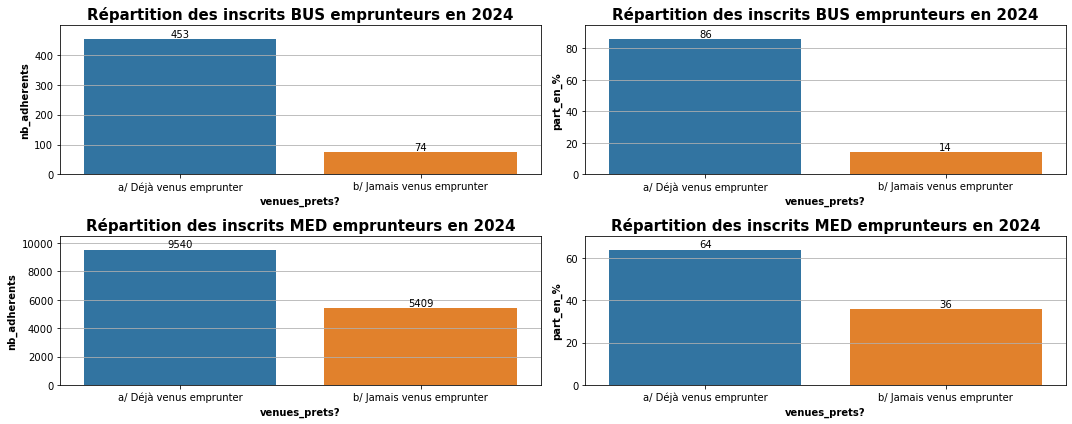

In [27]:
f,axs = plt.subplots(nrows=2,ncols=2,
                     #figsize=(10,10),
                    # sharex=True,sharey=True
                    )

plt.rcParams.update({'figure.subplot.hspace':0.9})

# ZEBRE 
sns.barplot(data=repartition_empr_distincts_bus_lastyear,
            x=repartition_empr_distincts_bus_lastyear.index,
            y='nb_adherents',
            ax=axs[0,0])
axs[0,0].set_ylim(top=repartition_empr_distincts_bus_lastyear['nb_adherents'].max()*1.1)
    
sns.barplot(data=repartition_empr_distincts_bus_lastyear,
            x=repartition_empr_distincts_bus_lastyear.index,
            y='part_en_%',
            ax=axs[0,1])
axs[0,1].set_ylim(top=repartition_empr_distincts_bus_lastyear['part_en_%'].max()*1.1)

sns.barplot(data=repartition_empr_distincts_med_lastyear,
            x=repartition_empr_distincts_med_lastyear.index,
            y='nb_adherents',
            ax=axs[1,0])
axs[1,0].set_ylim(top=repartition_empr_distincts_med_lastyear['nb_adherents'].max()*1.1)
    
sns.barplot(data=repartition_empr_distincts_med_lastyear,
            x=repartition_empr_distincts_med_lastyear.index,
            y='part_en_%',
            ax=axs[1,1])
axs[1,1].set_ylim(top=repartition_empr_distincts_med_lastyear['part_en_%'].max()*1.1)


#TITRES
axs[0,0].set_title(f"Répartition des inscrits BUS emprunteurs en {last_year}")
axs[0,1].set_title(f"Répartition des inscrits BUS emprunteurs en {last_year}")
axs[1,0].set_title(f"Répartition des inscrits MED emprunteurs en {last_year}")
axs[1,1].set_title(f"Répartition des inscrits MED emprunteurs en {last_year}")

# AFFICHAGE DES VALEURS
a=0
b=0
x=0

for x in range(0,4):
    for i in axs[a,b].containers:
        axs[a,b].bar_label(i,)
        if x % 2 > 0:
            a+=1
            b=0
        else:
            a+=0
            b=1
    
f.tight_layout()

# Circulation des emprunteurs

In [28]:
adh_lastyear_circ_inscr_bus = get_RepartitionAdherents(df=adh_lastyear,
                                             column='CirculationDesPublics',
                                             filter_on='inscription_code_site',
                                             filter_value='BUS'
                                            )

adh_refyear_circ_inscr_bus = get_RepartitionAdherents(df=adh_refyear,
                                             column='CirculationDesPublics',
                                             filter_on='inscription_code_site',
                                             filter_value='BUS'
                                            )



adh_lastyear_circ_inscr_med = get_RepartitionAdherents(df=adh_lastyear,
                                             column='CirculationDesPublics',
                                             filter_on='inscription_code_site',
                                             filter_value='MED'
                                            )

adh_refyear_circ_inscr_med = get_RepartitionAdherents(df=adh_refyear,
                                             column='CirculationDesPublics',
                                             filter_on='inscription_code_site',
                                             filter_value='MED'
                                            )

In [29]:
adh_lastyear_circ_inscr = get_RepartitionAdherents(df=adh_lastyear,
                                             column='CirculationDesPublics')

adh_refyear_circ_inscr = get_RepartitionAdherents(df=adh_refyear,
                                             column='CirculationDesPublics')

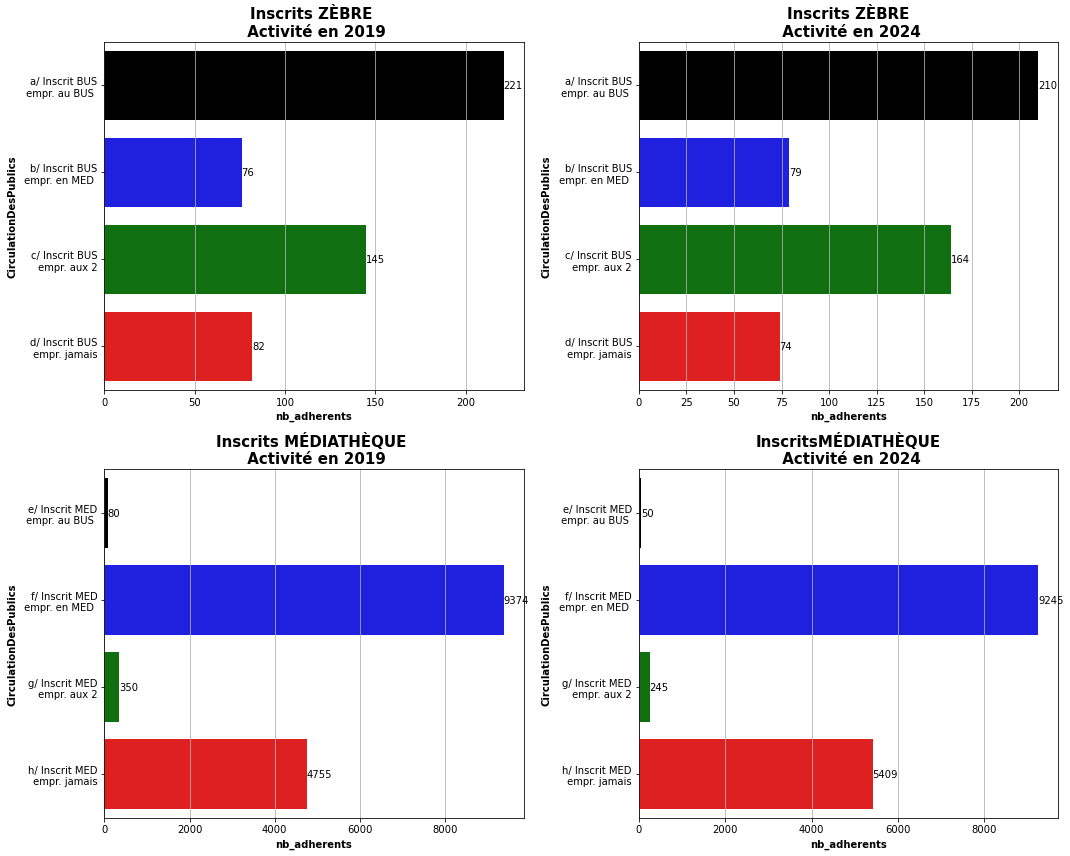

In [30]:
f,axs = plt.subplots(nrows=2,
                     ncols=2,
                     figsize=(15,12),
                     #sharey=True
                    )
cls = ['black','blue','green','red']

sns.barplot(data=adh_refyear_circ_inscr_bus,
            y=adh_refyear_circ_inscr_bus.index,
            x='nb_adherents',
            orient='h',palette=cls,
            ax=axs[0,0]
           )
sns.barplot(data=adh_lastyear_circ_inscr_bus,
            y=adh_lastyear_circ_inscr_bus.index,
            x='nb_adherents',
            orient='h',palette=cls,
            ax=axs[0,1]
           )
 
sns.barplot(data=adh_refyear_circ_inscr_med,
            y=adh_refyear_circ_inscr_med.index,
            x='nb_adherents',
            orient='h',palette=cls,
            ax=axs[1,0]
           )
sns.barplot(data=adh_lastyear_circ_inscr_med,
            y=adh_lastyear_circ_inscr_med.index,
            x='nb_adherents',
            orient='h',palette=cls,
            ax=axs[1,1]
           )
# TITRES
axs[0,0].set_title(f'Inscrits ZÈBRE \n Activité en {ref_year}')
axs[0,1].set_title(f'Inscrits ZÈBRE\n Activité en {last_year}')
axs[1,0].set_title(f'Inscrits MÉDIATHÈQUE \n Activité en {ref_year}')
axs[1,1].set_title(f'InscritsMÉDIATHÈQUE\n Activité en {last_year}')


# AFFICHAGE DES VALEURS
a=0
b=0
x=0

for x in range(0,4):
    for i in axs[a,b].containers:
        axs[a,b].bar_label(i,)
        if x % 2 > 0:
            a+=1
            b=0
        else:
            a+=0
            b=1
f.tight_layout()

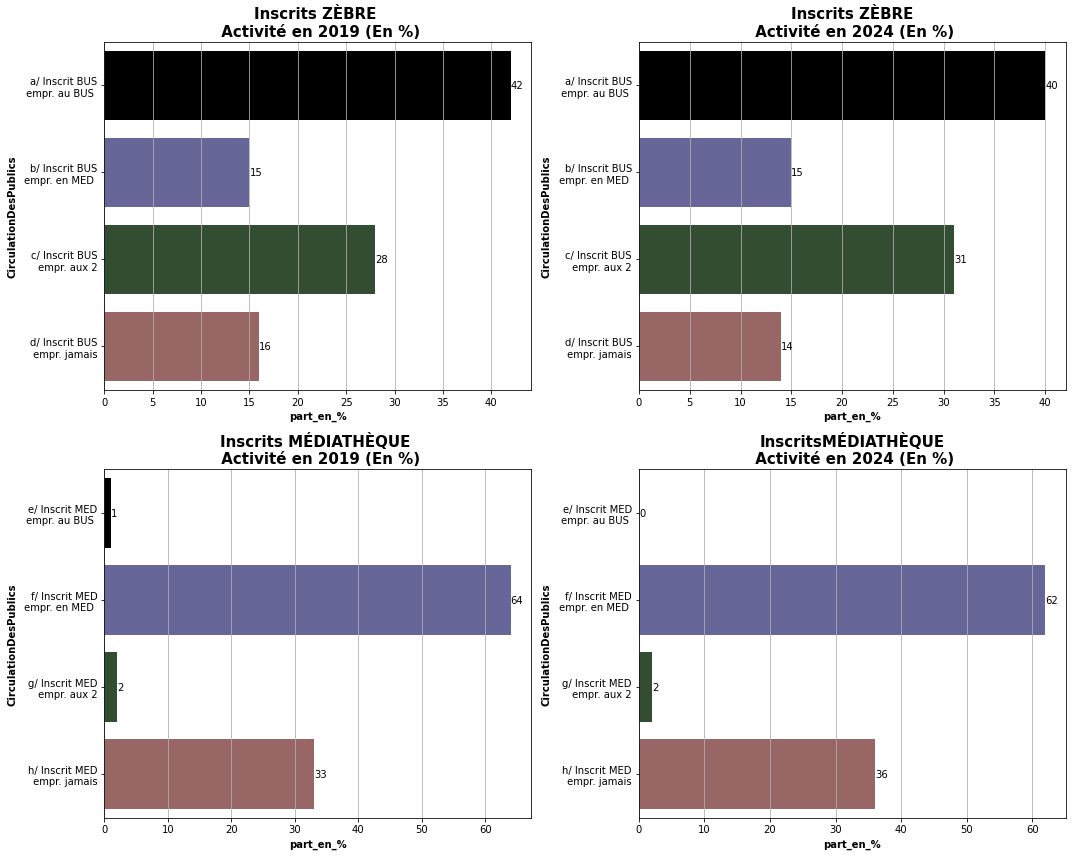

In [31]:
f,axs = plt.subplots(nrows=2,
                     ncols=2,
                     figsize=(15,12),
                     #sharey=True
                    )
cls = ['black','blue','green','red']

sns.barplot(data=adh_refyear_circ_inscr_bus,
            y=adh_refyear_circ_inscr_bus.index,
            x='part_en_%',
            orient='h',palette=cls,saturation=0.2,
            ax=axs[0,0]
           )
sns.barplot(data=adh_lastyear_circ_inscr_bus,
            y=adh_lastyear_circ_inscr_bus.index,
            x='part_en_%',
            orient='h',palette=cls,saturation=0.2,
            ax=axs[0,1]
           )
 
sns.barplot(data=adh_refyear_circ_inscr_med,
            y=adh_refyear_circ_inscr_med.index,
            x='part_en_%',
            orient='h',palette=cls,saturation=0.2,
            ax=axs[1,0]
           )
sns.barplot(data=adh_lastyear_circ_inscr_med,
            y=adh_lastyear_circ_inscr_med.index,
            x='part_en_%',
            orient='h',palette=cls,saturation=0.2,
            ax=axs[1,1]
           )
# TITRES
axs[0,0].set_title(f'Inscrits ZÈBRE \n Activité en {ref_year} (En %)')
axs[0,1].set_title(f'Inscrits ZÈBRE\n Activité en {last_year} (En %)')
axs[1,0].set_title(f'Inscrits MÉDIATHÈQUE \n Activité en {ref_year} (En %)')
axs[1,1].set_title(f'InscritsMÉDIATHÈQUE\n Activité en {last_year} (En %)')


# AFFICHAGE DES VALEURS
a=0
b=0
x=0

for x in range(0,4):
    for i in axs[a,b].containers:
        axs[a,b].bar_label(i,)
        if x % 2 > 0:
            a+=1
            b=0
        else:
            a+=0
            b=1
f.tight_layout()

# Répartition des prêts par arrêt

In [55]:
c2l = Code2Libelle(db_conn)

In [56]:
c2l.get_val()

In [57]:
dico = c2l.dict_codes_lib

In [58]:
query = f"""SELECT * 
FROM statdb.stat_issues si 
WHERE YEAR(issuedate) = {last_year}"""

prets = pd.read_sql(query,db_conn)

In [60]:
#repartition_prets_by_arrets_lastyear = get_RepartitionPrets(df=prets,column='arret_bus').rename(index=dico['attributs'])
repartition_prets_by_arrets_lastyear = get_RepartitionPrets(df=prets,column='arret_bus')

In [63]:
repartition_prets_by_arrets_lastyear = repartition_prets_by_arrets_lastyear.rename(index=dico['attributs'])

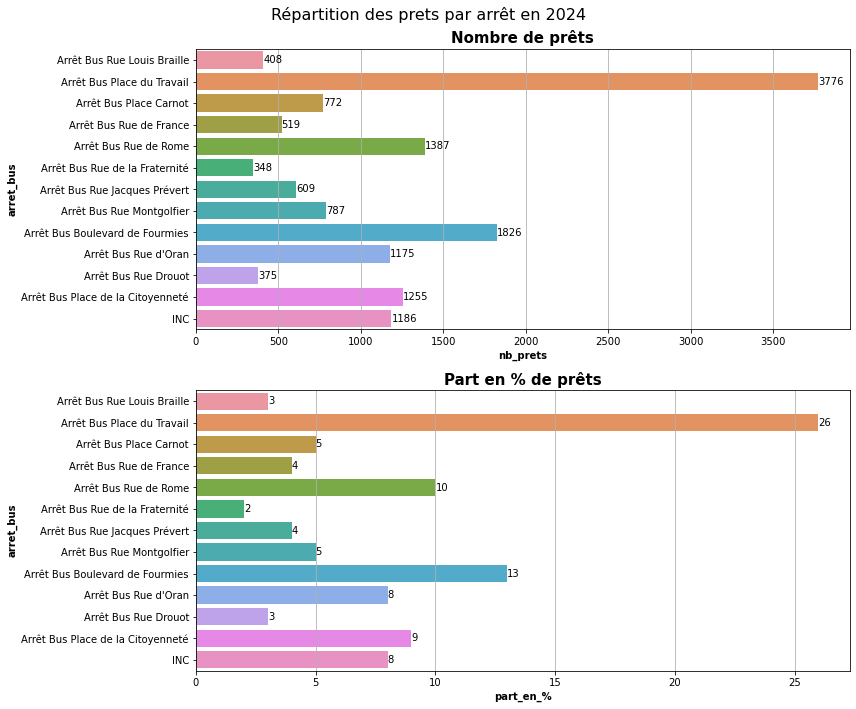

In [64]:
f,ax = plt.subplots(nrows=2,figsize=(12,10))


sns.barplot(data=repartition_prets_by_arrets_lastyear,
            y=repartition_prets_by_arrets_lastyear.index,
            x='nb_prets',orient='h',ax=ax[0],)


    
sns.barplot(data=repartition_prets_by_arrets_lastyear,
            y=repartition_prets_by_arrets_lastyear.index,
            x='part_en_%',orient='h',ax=ax[1])


    
# TITRES
f.suptitle(f'Répartition des prets par arrêt en {last_year}', fontsize=16)
ax[0].set_title("Nombre de prêts")
ax[1].set_title("Part en % de prêts")

x = 0
while x < 2 :
    for i in ax[x].containers:
        ax[x].bar_label(i,)
        x+=1

f.tight_layout()

# Attractivité du service 
## Evolution des inscrits

In [38]:
query = """SELECT 
                DATE_FORMAT(date_extraction, '%%Y-%%m') AS mois,
                inscription_code_site AS site_inscription,
                COUNT(*) AS total_inscrits_enregistres
            FROM 
                statdb.stat_adherents sa 
            WHERE inscription_code_site != 'MUS'
            GROUP BY 
                DATE_FORMAT(date_extraction, '%%Y-%%m'),inscription_code_site
            ORDER BY 
                mois;"""

In [39]:
dico_mois = {f'{last_year}-01':'01\nJan',
             f'{last_year}-02':'02\nFev',
             f'{last_year}-03':'03\nMar',
             f'{last_year}-04':'04\nAvr',
             f'{last_year}-05':'05\nMai',
             f'{last_year}-06':'06\nJuin',
             f'{last_year}-07':'07\nJuil',
             f'{last_year}-08':'08\nAou',
             f'{last_year}-09':'09\nSep',
             f'{last_year}-10':'10\nOct',
             f'{last_year}-11':'11\nNov',
             f'{last_year}-12':'12\nDec',
            }

In [40]:
evolution_inscrits = pd.read_sql(query,db_conn)

In [41]:
evolution_inscrits['mois'].fillna('vide',inplace=True)

In [42]:
evolution_inscrits_2024 = evolution_inscrits[evolution_inscrits['mois'].str.startswith(last_year_str)]

In [43]:
evolution_inscrits_2024.replace({'mois':dico_mois},inplace=True)

In [44]:
evolution_inscrits_2024_by_site = evolution_inscrits_2024.pivot(index='mois',columns='site_inscription',values='total_inscrits_enregistres')

In [45]:
evolution_inscrits_2024_bus = evolution_inscrits_2024[evolution_inscrits_2024['site_inscription']=='BUS'].groupby('mois')['total_inscrits_enregistres'].sum().to_frame()
evolution_inscrits_2024_med = evolution_inscrits_2024[evolution_inscrits_2024['site_inscription']=='MED'].groupby('mois')['total_inscrits_enregistres'].sum().to_frame()

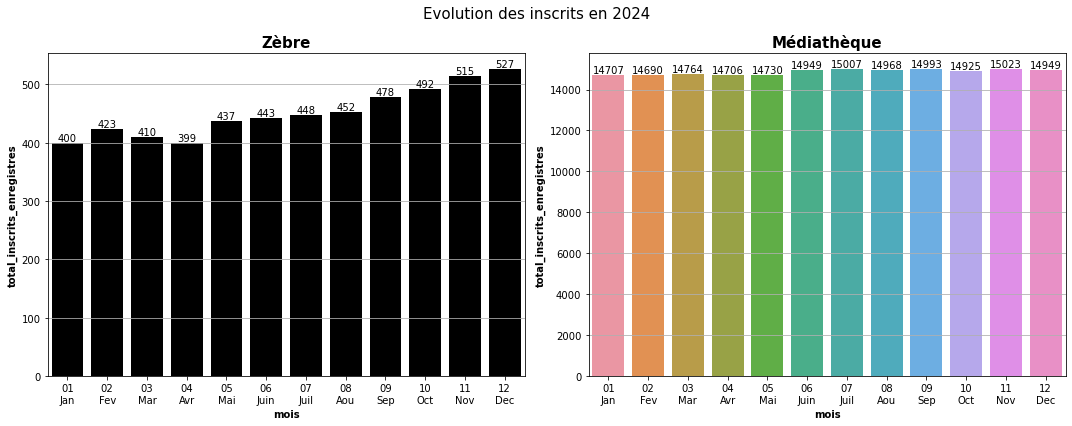

In [46]:
f,ax = plt.subplots(ncols=2,
                    #sharey=True
                   )

sns.barplot(data=evolution_inscrits_2024_bus,
            x=evolution_inscrits_2024_bus.index,
            y='total_inscrits_enregistres',
            color= 'black',
            ax=ax[0])
sns.barplot(data=evolution_inscrits_2024_med,x=evolution_inscrits_2024_med.index,y='total_inscrits_enregistres',ax=ax[1])

plt.suptitle(f'Evolution des inscrits en {last_year}',fontsize=15)
ax[0].set_title('Zèbre')
ax[1].set_title('Médiathèque')

x = 0
while x < 2:
    for i in ax[x].containers:
        ax[x].bar_label(i,)
        x = x + 1
        
f.tight_layout()

## Les nouveaux inscrits

In [47]:
repartition_adh_bus_lastyear_by_annee_fidelite = get_RepartitionAdherents(df=adh_lastyear_bus,
                                                                          column=adh_lastyear_bus['FideliteInscription'])


repartition_adh_med_lastyear_by_annee_fidelite = get_RepartitionAdherents(df=adh_lastyear_med,
                                                                          column=adh_lastyear_med['FideliteInscription']
                                                                         )

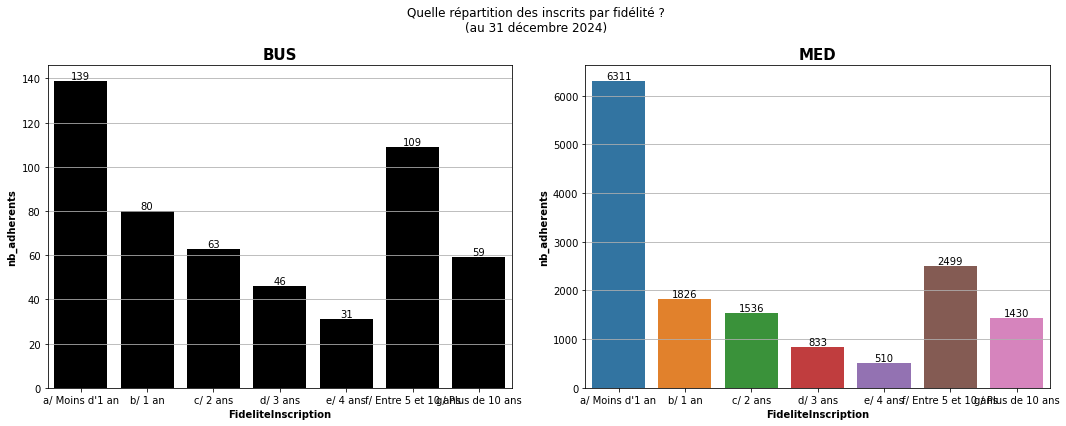

In [48]:
f,ax = plt.subplots(ncols=2)

sns.barplot(data=repartition_adh_bus_lastyear_by_annee_fidelite,
            x=repartition_adh_bus_lastyear_by_annee_fidelite.index,
            y='nb_adherents',
            ax=ax[0],
            color='black'
           )

sns.barplot(data=repartition_adh_med_lastyear_by_annee_fidelite,
            x=repartition_adh_med_lastyear_by_annee_fidelite.index,
            y='nb_adherents',
            ax=ax[1]
           )
# TITRES
plt.suptitle(f"Quelle répartition des inscrits par fidélité ?\n(au 31 décembre {last_year})")
ax[0].set_title(f'BUS')
ax[1].set_title(f'MED')


x = 0
while x < 2 :
    for i in ax[x].containers:
        ax[x].bar_label(i,)
        x+=1
        
f.tight_layout()

In [49]:
#ALGORITHME FONCTIONNEL !

#a = 0
#b = 0
#x = 0

#for x in range(0,8):
#    print(a,b)
#    if x % 2 > 0:
#        a+=1
#        b=0
#    else:
#        a+=0
#        b=1

# Prêts à domicile (Mireille)

In [106]:
liste_cartes_prets_domicile = ('X0002739083',
                               'X0002290393',
                               'X0002697604',
                               'X0002741468',
                               'X0002761640',
                               'X0002287430',
                               'X0002338095',
                               'X0001530236',
                               'X0001908312')

In [107]:
query = f"""SELECT issuedate,cardnumber,sexe,fidelite,location,ccode,itemtype
FROM statdb.stat_issues si 
WHERE YEAR(issuedate) = '{last_year}'
AND categorycode = 'COLI'
AND cardnumber IN {liste_cartes_prets_domicile}"""

In [108]:
prets_a_domicile = pd.read_sql(query,db_conn)

In [109]:
prets_a_domicile

,issuedate,cardnumber,sexe,fidelite,location,ccode,itemtype
0,2024-01-04 14:05:41,X0002290393,F,1,MED1A,ALTROZZ,LI
1,2024-01-04 14:05:43,X0002290393,F,1,MED1A,ALTROZZ,LI
2,2024-01-04 14:05:45,X0002290393,F,1,MED1A,ALTROPL,LI
3,2024-01-04 14:05:49,X0002290393,F,1,MED1A,ALTROZZ,LI
4,2024-01-04 14:07:38,X0001908312,F,10,MED1A,ALTROPL,LI
...,...,...,...,...,...,...,...
453,2024-12-21 16:33:49,X0002739083,N,19,MED1A,ALTROAM,LI
454,2024-12-21 16:33:51,X0002739083,N,19,MED1A,ALTROAM,LI
455,2024-12-21 16:33:54,X0002739083,N,19,MED1A,ALTROAM,LI
456,2024-12-21 16:33:57,X0002739083,N,19,MED1A,ALTROAM,LI


In [110]:
query2 = f"SELECT cardnumber,surname,firstname FROM koha_prod.borrowers WHERE cardnumber IN {liste_cartes_prets_domicile}"

In [111]:
cartes_prets_domicile = pd.read_sql(query2,db_conn)

In [112]:
cartes_prets_domicile

,cardnumber,surname,firstname
0,X0001530236,ZEBRE / PRET A DOMICILE MIREILLE / LAMBERT,Ginette
1,X0001908312,ZEBRE / PRET A DOMICILE MIREILLE / VANDEKERCKHOVE,Arlette
2,X0002287430,ZEBRE / PRET A DOMICILE MIREILLE / CORNIL,Yvette
3,X0002290393,ZEBRE / PRET A DOMICILE / MIREILLE / RECULE,Jacqueline
4,X0002338095,ZEBRE / PRET A DOMICILE MIREILLE / KALEM,Smaïl
5,X0002697604,ZEBRE / PRET A DOMICILE MIREILLE / BLEUZÉ,Christian
6,X0002739083,Z / PRET A DOMICILE MIREILLE FOURNIER,Micheline
7,X0002741468,ZEBRE / PRET A DOMICILE MIREILLE / BOSSUT,Françoise
8,X0002761640,ZEBRE / PRET A DOMICILE MIREILLE / COLLET,Mireille


In [113]:
prets_a_domicile_lib = prets_a_domicile.merge(cartes_prets_domicile,right_on='cardnumber',left_on='cardnumber',how='left')

In [114]:
prets_a_domicile_lib['Nom de carte'] = prets_a_domicile_lib['surname'] + prets_a_domicile_lib['firstname']

In [115]:
prets_a_domicile_lib

,issuedate,cardnumber,sexe,fidelite,location,ccode,itemtype,surname,firstname,Nom de carte
0,2024-01-04 14:05:41,X0002290393,F,1,MED1A,ALTROZZ,LI,ZEBRE / PRET A DOMICILE / MIREILLE / RECULE,Jacqueline,ZEBRE / PRET A DOMICILE / MIREILLE / RECULEJac...
1,2024-01-04 14:05:43,X0002290393,F,1,MED1A,ALTROZZ,LI,ZEBRE / PRET A DOMICILE / MIREILLE / RECULE,Jacqueline,ZEBRE / PRET A DOMICILE / MIREILLE / RECULEJac...
2,2024-01-04 14:05:45,X0002290393,F,1,MED1A,ALTROPL,LI,ZEBRE / PRET A DOMICILE / MIREILLE / RECULE,Jacqueline,ZEBRE / PRET A DOMICILE / MIREILLE / RECULEJac...
3,2024-01-04 14:05:49,X0002290393,F,1,MED1A,ALTROZZ,LI,ZEBRE / PRET A DOMICILE / MIREILLE / RECULE,Jacqueline,ZEBRE / PRET A DOMICILE / MIREILLE / RECULEJac...
4,2024-01-04 14:07:38,X0001908312,F,10,MED1A,ALTROPL,LI,ZEBRE / PRET A DOMICILE MIREILLE / VANDEKERCKHOVE,Arlette,ZEBRE / PRET A DOMICILE MIREILLE / VANDEKERCKH...
...,...,...,...,...,...,...,...,...,...,...
453,2024-12-21 16:33:49,X0002739083,N,19,MED1A,ALTROAM,LI,Z / PRET A DOMICILE MIREILLE FOURNIER,Micheline,Z / PRET A DOMICILE MIREILLE FOURNIERMicheline
454,2024-12-21 16:33:51,X0002739083,N,19,MED1A,ALTROAM,LI,Z / PRET A DOMICILE MIREILLE FOURNIER,Micheline,Z / PRET A DOMICILE MIREILLE FOURNIERMicheline
455,2024-12-21 16:33:54,X0002739083,N,19,MED1A,ALTROAM,LI,Z / PRET A DOMICILE MIREILLE FOURNIER,Micheline,Z / PRET A DOMICILE MIREILLE FOURNIERMicheline
456,2024-12-21 16:33:57,X0002739083,N,19,MED1A,ALTROAM,LI,Z / PRET A DOMICILE MIREILLE FOURNIER,Micheline,Z / PRET A DOMICILE MIREILLE FOURNIERMicheline


# Prêts aux EPHAD

In [116]:
liste_cartes_EPHAD = ('X0002706740',
                      'X0002519098',
                      'X0002561783',
                      'X0002740836',
                      'X0002652269',
                      'X0002558233'
                     )

In [117]:
query3 = f"""SELECT cardnumber,surname,firstname FROM koha_prod.borrowers WHERE cardnumber IN {liste_cartes_EPHAD}"""

In [118]:
cartes_prets_EPHAD = pd.read_sql(query3,db_conn)

In [119]:
cartes_prets_EPHAD

,cardnumber,surname,firstname
0,X0002519098,RÉSIDENCE DE LA FRATERNITE,None
1,X0002558233,VILLA ARMONIA,None
2,X0002561783,RÉSIDENCE DES TOILES DE BEAUMONT,None
3,X0002652269,RÉSIDENCE LES ORCHIDEES,None
4,X0002706740,RÉSIDENCE BEAUMONT,None
5,X0002740836,RESIDENCE LES JARDINS DU VELODROME,None


In [120]:
query4 = f"""SELECT issuedate,cardnumber,sexe,fidelite,location,ccode,itemtype
FROM statdb.stat_issues si 
WHERE YEAR(issuedate) = '{last_year}'
AND categorycode = 'COLI'
AND cardnumber IN {cartes_EPHAD}"""

In [121]:
prets_EPHAD = pd.read_sql(query4,db_conn)

In [122]:
prets_EPHAD_lib = prets_EPHAD.merge(cartes_prets_EPHAD,right_on='cardnumber',left_on='cardnumber',how='left')

In [123]:
prets_EPHAD_lib

,issuedate,cardnumber,sexe,fidelite,location,ccode,itemtype,surname,firstname
0,2024-01-23 14:40:05,X0002558233,NP,2,MED1A,ALTROZZ,LI,VILLA ARMONIA,None
1,2024-01-23 14:40:11,X0002558233,NP,2,MED1A,ALTROZZ,LI,VILLA ARMONIA,None
2,2024-01-23 14:40:16,X0002558233,NP,2,MED1A,ALTROZZ,LI,VILLA ARMONIA,None
3,2024-01-23 14:40:19,X0002558233,NP,2,MED1A,ALTROZZ,LI,VILLA ARMONIA,None
4,2024-01-23 14:40:23,X0002558233,NP,2,MED1A,ALTROZZ,LI,VILLA ARMONIA,None
...,...,...,...,...,...,...,...,...,...
1722,2024-12-11 14:37:29,X0002652269,N,1,MED3A,ACFHSZZ,LI,RÉSIDENCE LES ORCHIDEES,None
1723,2024-12-11 14:37:34,X0002652269,N,1,MED3A,ACFHSZZ,LI,RÉSIDENCE LES ORCHIDEES,None
1724,2024-12-11 14:37:51,X0002652269,N,1,MED3A,ACFHSZZ,LI,RÉSIDENCE LES ORCHIDEES,None
1725,2024-12-11 14:37:56,X0002652269,N,1,MED3A,ACFHSZZ,LI,RÉSIDENCE LES ORCHIDEES,None


In [124]:
repartition_prets_a_domicile_by_emprunteur = get_RepartitionPrets(df=prets_a_domicile_lib,column='surname')

In [133]:
repartition_prets_EPHAD = get_RepartitionPrets(df=prets_EPHAD_lib,column='surname')

In [134]:
repartition_prets_EPHAD

,nb_prets,part_en_%
surname,,
RESIDENCE LES JARDINS DU VELODROME,191,11
RÉSIDENCE BEAUMONT,378,22
RÉSIDENCE DE LA FRATERNITE,313,18
RÉSIDENCE DES TOILES DE BEAUMONT,309,18
RÉSIDENCE LES ORCHIDEES,281,16
VILLA ARMONIA,255,15


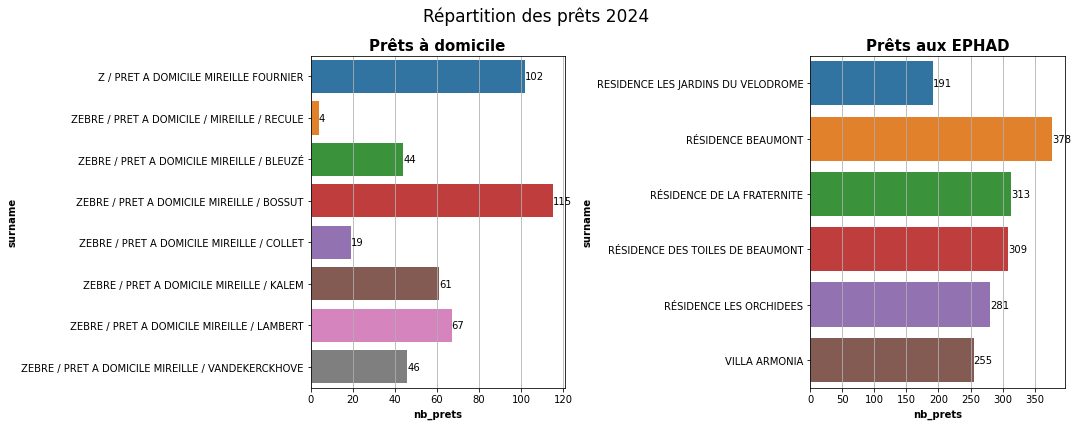

In [143]:
f,ax = plt.subplots(ncols=2)

sns.barplot(data=repartition_prets_a_domicile_by_emprunteur,
            y=repartition_prets_a_domicile_by_emprunteur.index,
            x='nb_prets',
            orient='h',
            ax=ax[0]
           )
sns.barplot(data=repartition_prets_EPHAD,
            y=repartition_prets_EPHAD.index,
            x='nb_prets',
            orient='h',
            ax=ax[1]
           )

plt.suptitle(f"Répartition des prêts {last_year}",fontsize=17)
ax[0].set_title("Prêts à domicile")
ax[1].set_title("Prêts aux EPHAD")

x = 0
while x < 2:
    for i in ax[x].containers:
        ax[x].bar_label(i,)
        x+=1

f.tight_layout()